## LSTM Multivariate Model for Bitcoin, Ethereum and Litecoin Crypto 

In [ ]:
# Import libraries
from pathlib import Path
import pandas as pd
import numpy as np
import hvplot.pandas
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Assign random seed for reproducibility 
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Clean Up

In [ ]:
# Define CSV paths
btc_csv_path = Path("/content/drive/MyDrive/Group_Project_2/BTC_USD_data.csv")
eth_csv_path = Path("/content/drive/MyDrive/Group_Project_2/ETH_USD_data.csv")
ltc_csv_path = Path("/content/drive/MyDrive/Group_Project_2/LTC_USD_data.csv")

In [ ]:
# Read CSVs to DataFrames
btc_df = pd.read_csv(btc_csv_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
eth_df = pd.read_csv(eth_csv_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
ltc_df = pd.read_csv(ltc_csv_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
btc_df.head()

,BTC
Date,
2016-01-01,433.82
2016-01-02,433.55
2016-01-03,431.04
2016-01-04,434.17
2016-01-05,432.43


In [ ]:
# Create list of DataFrames
dfs = [btc_df, eth_df, ltc_df]

## Data Prep

In [ ]:
# Fuction to calculate RSI
def relative_strength_idx(df, n=14):
    close = df
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

In [ ]:
# Create EMA and RSI columns
for df in dfs: 
  df['EMA_5'] = df.ewm(5).mean().shift()
  df_rsi = relative_strength_idx(df, n=14) 
  df['RSI'] = df_rsi[df_rsi.columns[0]]

In [ ]:
# Build the LSTM model

def lstm_model(X_train):
  model = Sequential()

  number_units = 40
  dropout_fraction = 0.3

  # Layer 1
  model.add(LSTM(
      units=number_units,
      return_sequences=True,
      input_shape=(X_train.shape[1], 1))
      )
  model.add(Dropout(dropout_fraction))
  # Layer 2
  model.add(LSTM(units=number_units, return_sequences=True))
  model.add(Dropout(dropout_fraction))
  # Layer 3
  model.add(LSTM(units=number_units, return_sequences=True))
  model.add(Dropout(dropout_fraction))
  # Layer 4
  model.add(LSTM(units=number_units))
  model.add(Dropout(dropout_fraction))
  # Output layer
  model.add(Dense(1))

  return model
  

## Run the Model

In [ ]:
# Predict Closing Prices 

scalers={}
test = []
pred_results = []

for df in dfs:
  scaler = MinMaxScaler()

  # Slice the data for after the shock
  df = df.loc['2020-03-01': '2021-05-03']

  # Split data into feature(X) and target(y)
  X = df
  y = df.iloc[:,0]
  y = np.array(y).reshape(-1,1)

  # Split into training and testing sets
  split_ratio = 0.8
  split = int(split_ratio * len(df))
  X_train = X[: split]
  X_test = X[split:]
  y_train = y[: split]
  y_test = y[split:]

  # Scale the data
  scaler.fit(X)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  scaler.fit(y)
  y_train = scaler.transform(y_train)
  y_test = scaler.transform(y_test)
  
  test.append(y_test)

  scalers[df.columns[0]]=scaler

  # Reshape the data
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  # Call the LSTM model function
  model = lstm_model(X_train)

  # Compile the model
  model.compile(optimizer="adamax", loss="mean_squared_error")

  # Fit the model
  model.fit(X_train, y_train, epochs=15, shuffle=False, batch_size=2)

  print(model.evaluate(X_test, y_test))

  # Make predictions
  predicted = model.predict(X_test)

  pred_results.append(predicted)

Epoch 1/15
172/172 [==============================] - 7s 8ms/step - loss: 0.0011
Epoch 2/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0575
Epoch 3/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0230
Epoch 4/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0242
Epoch 5/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0239
Epoch 6/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0162
Epoch 7/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0061
Epoch 8/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0036
Epoch 9/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 10/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 11/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0014
Epoch 12/15
172/172 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 13/15
172/172 [====

## Review Results

In [ ]:
# Recover the original and predicted Bitcoin prices
btc_predicted= scalers["BTC"].inverse_transform(pred_results[0]).ravel()
btc_real = scalers["BTC"].inverse_transform(test[0].reshape(-1, 1)).ravel()

In [ ]:
# Create DataFrame of Bitcoin Real and Predicted values
btc_predict = pd.DataFrame({
    "Real": btc_real,
    "Predicted": btc_predicted
}, index = btc_df.index[-len(btc_real): ]) 
btc_predict.head()

,Real,Predicted
Date,,
2021-02-07,38858.39,36802.488281
2021-02-08,46416.45,43339.777344
2021-02-09,46505.20,43979.164062
2021-02-10,44854.63,43282.453125
2021-02-11,47981.48,46018.601562


In [ ]:
# Calculate Bitcoin MSE & RMSE
btc_mse = mean_squared_error(btc_real, btc_predicted)
btc_rmse = math.sqrt(btc_mse)
btc_mean = btc_predicted.mean()
print(f"Bitcoin Mean Square Error: {btc_mse}")
print(f"Bitcoin Root Mean Square Error: {btc_rmse}")
print(f"Bitcoin Mean Predicted Closing Price: {btc_mean}")

Bitcoin Mean Square Error: 1117080.1059691766
Bitcoin Root Mean Square Error: 1056.9201038721785
Bitcoin Mean Predicted Closing Price: 53705.0390625


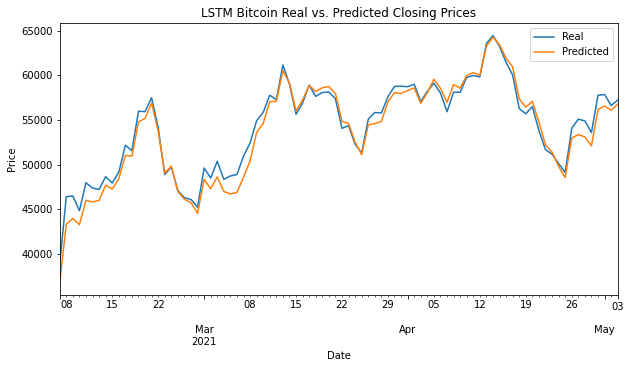

In [ ]:
# Plot Bitcoin real vs predicted prices
btc_predict.plot(title="LSTM Bitcoin Real vs. Predicted Closing Prices", figsize=(10,5), ylabel="Price");

In [ ]:
# Recover the original and predicted Ethereum prices
eth_predicted = scalers["ETH"].inverse_transform(pred_results[1]).ravel()
eth_real = scalers["ETH"].inverse_transform(test[1].reshape(-1, 1)).ravel()

In [ ]:
# Create DataFrame of Ethereum real and predicted values
eth_predict = pd.DataFrame({
    "Real": eth_real,
    "Predicted": eth_predicted
}, index = eth_df.index[-len(eth_real): ]) 
eth_predict.tail()

,Real,Predicted
Date,,
2021-04-29,2758.06,2782.773193
2021-04-30,2777.11,2831.983398
2021-05-01,2947.57,3006.385254
2021-05-02,2951.78,3047.262451
2021-05-03,3430.16,3440.794922


In [ ]:
# Calculate Ethereum MSE & RMSE
eth_mse = mean_squared_error(eth_real, eth_predicted)
eth_rmse = math.sqrt(eth_mse)
eth_mean = eth_predicted.mean()
print(f"Ethereum Mean Square Error: {eth_mse}")
print(f"Ethereum Root Mean Square Error: {eth_rmse}")
print(f"Ethereum Mean Predicted Closing Price: {eth_mean}")

Ethereum Mean Square Error: 2873.6340924439037
Ethereum Root Mean Square Error: 53.60628780697189
Ethereum Mean Predicted Closing Price: 1961.7474365234375


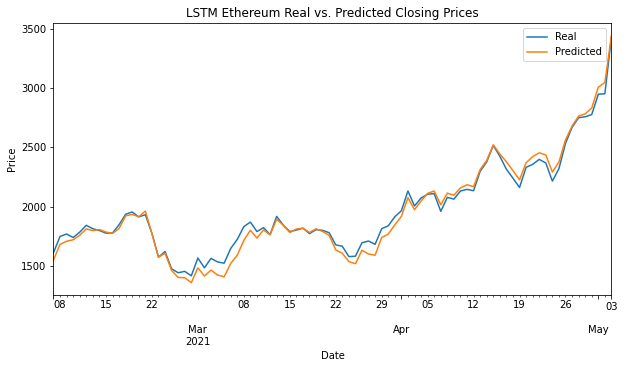

In [ ]:
# Plot Ethereum real vs predicted prices
eth_predict.plot(title="LSTM Ethereum Real vs. Predicted Closing Prices", figsize=(10,5), ylabel="Price");

In [ ]:
# Recover the original and predicted Litecoin prices
ltc_predicted = scalers["LTC"].inverse_transform(pred_results[2]).ravel()
ltc_real = scalers["LTC"].inverse_transform(test[2].reshape(-1, 1)).ravel()

In [ ]:
# Create DataFrame of Litecoin real and predicted values
ltc_predict = pd.DataFrame({
    "Real": ltc_real,
    "Predicted": ltc_predicted
}, index = ltc_df.index[-len(ltc_real): ]) 
ltc_predict.head()

,Real,Predicted
Date,,
2021-02-07,151.19,142.899200
2021-02-08,167.65,156.646088
2021-02-09,181.91,168.995956
2021-02-10,181.80,172.848755
2021-02-11,184.04,175.376740


In [ ]:
# Calculate Litecoin MSE & RMSE
ltc_mse = mean_squared_error(ltc_real, ltc_predicted)
ltc_rmse = math.sqrt(ltc_mse)
ltc_mean = ltc_predicted.mean()
print(f"Litecoin Mean Square Error: {ltc_mse}")
print(f"Litecoin Root Mean Square Error: {ltc_rmse}")
print(f"Litecoin Mean Predicted Closing Price: {ltc_mean}")

Litecoin Mean Square Error: 94.27937811764542
Litecoin Root Mean Square Error: 9.70975685162329
Litecoin Mean Predicted Closing Price: 207.64442443847656


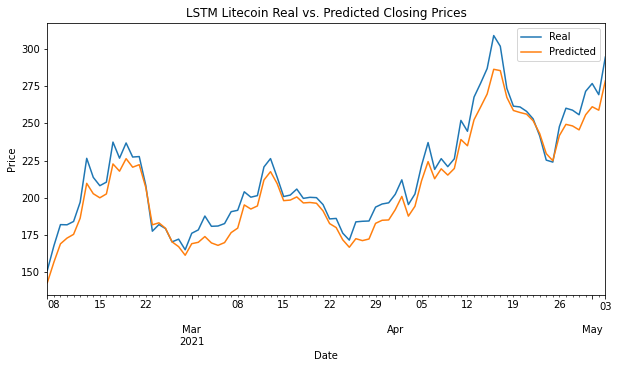

In [ ]:
# Plot Litecoin real vs predicted prices
ltc_predict.plot(title="LSTM Litecoin Real vs. Predicted Closing Prices", figsize=(10,5), ylabel="Price");